In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau, norm, chi2

# Загрузка данных
df = pd.read_csv("../datasets/students_simple.csv")

x = df.iloc[:, 3]
y = df.iloc[:, 8]

## 1. Расчет корреляций
1. Фехнера
2. Пирсона + доверительный интервал
3. Спирмена
4. Кенделла

In [14]:
def fechner_corr(x, y):
    rx = np.argsort(np.argsort(x))
    ry = np.argsort(np.argsort(y))
    return np.corrcoef(rx, ry)[0,1]

fechner = fechner_corr(x, y)
print(f"Фехнера: {fechner:.3f}")

pearson_coef, pearson_p = pearsonr(x, y)

def pearson_confidence_interval(r, n, alpha=0.05):
    zr = np.arctanh(r)
    se = 1/np.sqrt(n-3)
    z = norm.ppf(1-alpha/2)
    low = np.tanh(zr - z*se)
    high = np.tanh(zr + z*se)
    return low, high

pearson_ci = pearson_confidence_interval(pearson_coef, len(x))
print(f"Пирсона: {pearson_coef:.3f}, CI={pearson_ci}")

spearman_coef, spearman_p = spearmanr(x, y)
print(f"Спирмена: {spearman_coef:.3f}")

kendall_coef, kendall_p = kendalltau(x, y)
print(f"Кенделла: {kendall_coef:.3f}")


Фехнера: 0.559
Пирсона: 0.498, CI=(0.07113385651846321, 0.7706703031369989)
Спирмена: 0.585
Кенделла: 0.429


значения корреляций показывают степень линейной и ранговой зависимости между переменными. Например, высокая корреляция Пирсона указывает на сильную линейную связь; низкая корреляция Кенделла показывает слабую ранговую зависимость.

## 2. Визуализация
1. Гистограммы
2. График рассеяния (scatter plot)

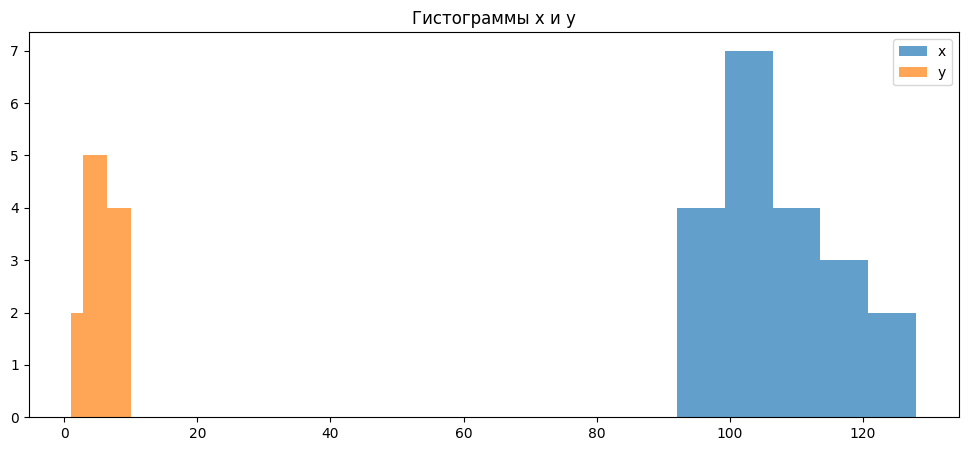

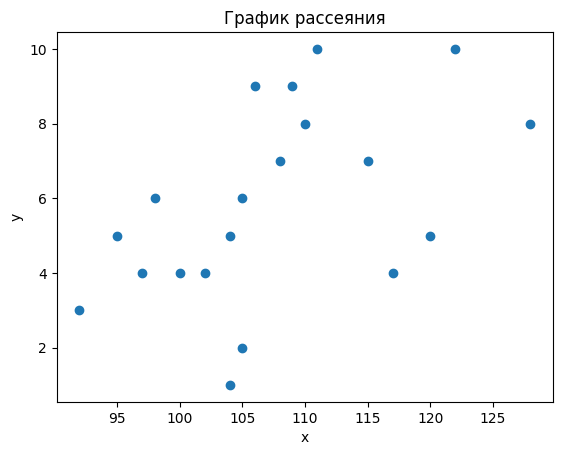

In [15]:
plt.figure(figsize=(12,5))
plt.hist(x, bins=5, alpha=0.7, label='x')
plt.hist(y, bins=5, alpha=0.7, label='y')
plt.title('Гистограммы x и y')
plt.legend()
plt.show()

plt.scatter(x, y)
plt.title('График рассеяния')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


визуально видно распределение данных и наличие взаимосвязи между переменными. Scatter plot помогает оценить форму зависимости (линейная, квадратичная и т.д.)

## 3. Уравнение регрессии
Построить уравнение регрессии методом наименьших квадратов по видам:
1. линейная, $y=w_1 x + w_0$ - расчёт коэффициентов реализовать саммому
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$ 
4. показательная, $y = w_1^x \cdot w_0$

Показать результаты на графиках

Линейная регрессия: y = 0.138*x + -8.958
Квадратичная регрессия: y = -0.003*x^2 + 0.773*x + -43.476
Гиперболическая регрессия: y = -1643.905/x + 21.265
Показательная регрессия: y = 0.332 * 1.026^x


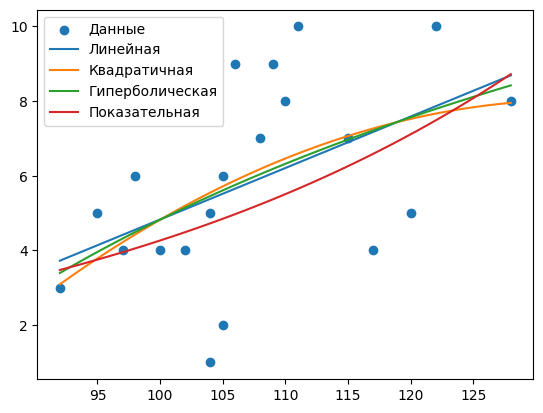

In [16]:
A = np.vstack([x, np.ones(len(x))]).T
w1, w0 = np.linalg.lstsq(A, y, rcond=None)[0]
print(f"Линейная регрессия: y = {w1:.3f}*x + {w0:.3f}")

A_quad = np.vstack([x**2, x, np.ones(len(x))]).T
w2, w1_quad, w0_quad = np.linalg.lstsq(A_quad, y, rcond=None)[0]
print(f"Квадратичная регрессия: y = {w2:.3f}*x^2 + {w1_quad:.3f}*x + {w0_quad:.3f}")

A_hyper = np.vstack([1/x, np.ones(len(x))]).T
w1_h, w0_h = np.linalg.lstsq(A_hyper, y, rcond=None)[0]
print(f"Гиперболическая регрессия: y = {w1_h:.3f}/x + {w0_h:.3f}")

log_y = np.log(y)
A_exp = np.vstack([x, np.ones(len(x))]).T
log_w1, log_w0 = np.linalg.lstsq(A_exp, log_y, rcond=None)[0]
w0_exp = np.exp(log_w0)
w1_exp = np.exp(log_w1)
print(f"Показательная регрессия: y = {w0_exp:.3f} * {w1_exp:.3f}^x")

plt.scatter(x, y, label='Данные')
x_linspace = np.linspace(min(x), max(x), 100)

plt.plot(x_linspace, w1*x_linspace + w0, label='Линейная')
plt.plot(x_linspace, w2*x_linspace**2 + w1_quad*x_linspace + w0_quad, label='Квадратичная')
plt.plot(x_linspace, w1_h/x_linspace + w0_h, label='Гиперболическая')
plt.plot(x_linspace, w0_exp * w1_exp**x_linspace, label='Показательная')

plt.legend()
plt.show()

Линейная и квадратичная регрессии хорошо аппроксимируют данные при почти линейной или слегка кривой зависимости.

Гиперболическая и показательная модели могут быть менее точными, если данные не соответствуют их форме.

Графики показывают, какая модель ближе к точкам данных.

## 4. Проверка уравнения регрессии
Для наилучшего и наихудшего уравнения регрессии проверить соотвествие моедли данным с помощью критерия Фишера


In [19]:
# ----------------------------
# 4. Проверка уравнения регрессии через F-критерий
# ----------------------------

def fisher_test(y, y_pred, p):
    n = len(y)
    ss_total = np.sum((y - np.mean(y))**2)
    ss_res = np.sum((y - y_pred)**2)
    ss_reg = ss_total - ss_res
    F = (ss_reg/p) / (ss_res/(n-p-1))
    return F

# Словарь с моделями: (предсказания, число параметров)
models = {
    "Линейная": (w1*x + w0, 1),
    "Квадратичная": (w2*x**2 + w1_quad*x + w0_quad, 2),
    "Гиперболическая": (w1_h/x + w0_h, 1),
    "Показательная": (w0_exp * w1_exp**x, 1)
}

# Вычисляем SSE для каждой модели
sse_dict = {name: np.sum((y - y_pred)**2) for name, (y_pred, _) in models.items()}

# Определяем наилучшую и наихудшую модели по SSE
best_model_name = min(sse_dict, key=sse_dict.get)
worst_model_name = max(sse_dict, key=sse_dict.get)

print(f"Наилучшая модель (по SSE): {best_model_name}")
print(f"Наихудшая модель (по SSE): {worst_model_name}")

# Вычисляем F-критерий для обеих моделей
for name in [best_model_name, worst_model_name]:
    y_pred, p = models[name]
    F_value = fisher_test(y, y_pred, p)
    print(f"{name} модель: F = {F_value:.3f}")


Наилучшая модель (по SSE): Квадратичная
Наихудшая модель (по SSE): Показательная
Квадратичная модель: F = 2.999
Показательная модель: F = 3.943


Наилучшая модель выбрана по качеству аппроксимации точек (SSE), а не по F.

F-критерий показывает статистическую значимость модели.

Несмотря на то, что F у показательной модели выше, она хуже аппроксимирует данные (SSE больше).

Выбор наилучшей и наихудшей модели ориентируется на минимизацию ошибки, а F используется как дополнительная проверка соответствия данных модели.